In [1]:
import pandas as pd

df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [2]:
df.info()

print("\nMissing Values:\n")
print(df.isnull().sum())

print("\nUnique Titles:", df['title'].nunique())

print("\nType Distribution\n", df['type'].value_counts())

print("\nTop Genres:")
df['listed_in'].value_counts().head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

Missing Values:

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
des

listed_in
Dramas, International Movies                        362
Documentaries                                       359
Stand-Up Comedy                                     334
Comedies, Dramas, International Movies              274
Dramas, Independent Movies, International Movies    252
Kids' TV                                            220
Children & Family Movies                            215
Children & Family Movies, Comedies                  201
Documentaries, International Movies                 186
Dramas, International Movies, Romantic Movies       180
Name: count, dtype: int64

In [3]:
df['description'] = df['description'].fillna('')
df = df.dropna(subset = ['title', 'listed_in'])
df = df.reset_index(drop = True)
print("Data Cleaned, Rows Remaining: ", len(df))

Data Cleaned, Rows Remaining:  8807


In [4]:
df['date_added'] = pd.to_datetime(df['date_added'], errors = 'coerce')
df['release_year'] = df['date_added'].dt.year
df['title_length'] = df['title'].apply(lambda x: len(str(x)))
df['description_word_count'] = df['description'].apply(lambda x: len(str(x).split()))
df['release_year'].fillna(df['release_year'].mode()[0], inplace = True)

C:\Users\Predator-User\AppData\Local\Temp\ipykernel_27108\3516533944.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['release_year'].fillna(df['release_year'].mode()[0], inplace = True)


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['clean_description'] = df['description'].apply(clean_text)


In [6]:
from sklearn.preprocessing import LabelEncoder

df['main_genre'] = df['listed_in'].apply(lambda x: x.split(',')[0].strip())

genre_counts = df['main_genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 50].index
df_filtered = df[df['main_genre'].isin(valid_genres)].copy().reset_index(drop = True)

le = LabelEncoder()
df_filtered['genre_label'] = le.fit_transform(df_filtered['main_genre'])

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_filtered['clean_description'] = df_filtered['description'].apply(clean_text)

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_filtered['clean_description'])

print("TF-IDF matrix shape:", tfidf_matrix.shape)


TF-IDF matrix shape: (8560, 19940)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("Cosine Similarity Matric Created")

Cosine Similarity Matric Created


In [9]:
indices = pd.Series(df.index, index=df['title'].str.lower())

def get_recommendation(title, cosine_sim=cosine_sim):
    title = title.lower()
    if title not in indices:
        return f"'{title}' not found in the dataset."
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:11]  

    recommended_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[recommended_indices]


In [10]:
get_recommendation("Breaking Bad")

2155    The Magic School Bus Rides Again Kids In Space
6583                                Death at a Funeral
6227                                      Bang Rajan 2
6175                                          Antidote
1561                                           Torbaaz
1851                                        One on One
2240                                       The Players
2425                              The Light of My Eyes
6091                                             Adore
7252                                          La Bamba
Name: title, dtype: object

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(tfidf_matrix)

df_filtered['cluster'] = kmeans.labels_
print("KMeans clustering done")
df_filtered[['title', 'cluster']].head(10)


KMeans clustering done


,title,cluster
0,Dick Johnson Is Dead,1
1,Blood & Water,6
2,Ganglands,0
3,Jailbirds New Orleans,5
4,Kota Factory,8
5,Midnight Mass,2
6,My Little Pony: A New Generation,1
7,Sankofa,1
8,The Great British Baking Show,1
9,The Starling,2


In [12]:
for i in range(10):
    print(f"\nCluster {i}:")
    print(df_filtered[df_filtered['cluster'] == i]['title'].sample(5, random_state=42).to_list())


Cluster 0:
['Red Christmas', 'The Amityville Horror', 'Clickbait', 'Yaara O Dildaara', 'Camellia Sisters']

Cluster 1:
['My Teacher, My Obsession', 'Steel Rain', 'Croupier', 'Lucid Dream', 'Pretville']

Cluster 2:
['Special', 'Susanne Bartsch: On Top', 'The End', 'A Princess for Christmas', 'Mary Magdalene']

Cluster 3:
['Lust Stories', 'Just The Way You Are', 'Colours of Passion', 'The Laws of Thermodynamics', 'Beating Again']

Cluster 4:
['Tracy Morgan: Staying Alive', 'Alan Saldaña: Locked Up', 'Unbreakable Kimmy Schmidt: Kimmy vs. the Reverend', 'Cooked with Cannabis', 'Chris Rock Total Blackout: The Tamborine Extended Cut']

Cluster 5:
['My Little Pony Equestria Girls: Legend of Everfree', 'YooHoo to the Rescue', 'City in the Sky', 'Origins Collection', 'The Innocence Files']

Cluster 6:
['The Shadow of Violence', 'My Little Pony Equestria Girls: Rollercoaster of Friendship', 'The Heroes of Evil', 'Dancing Queens', 'The Neighbor']

Cluster 7:
['Lila & Eve', 'Close Enemies', 'Toy 

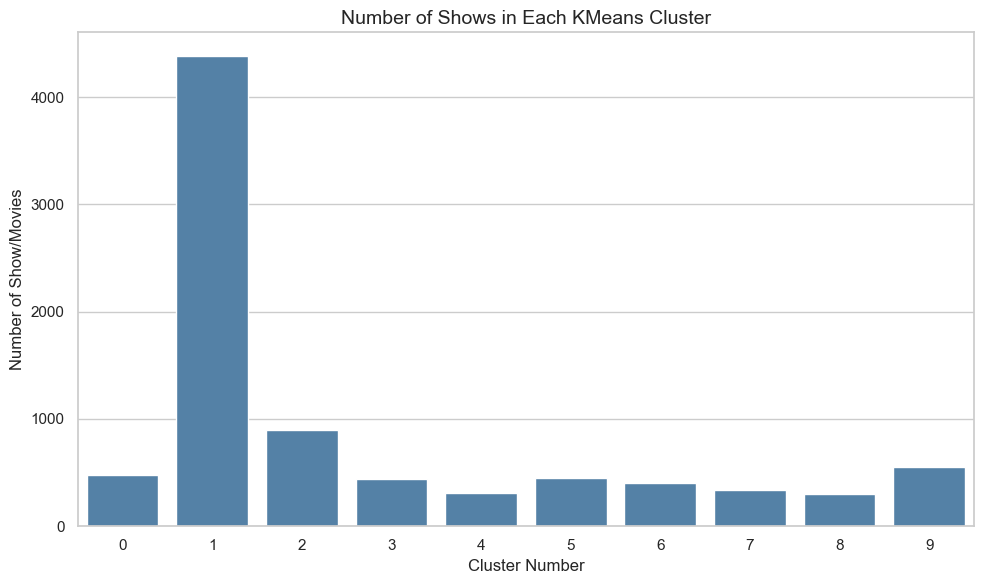

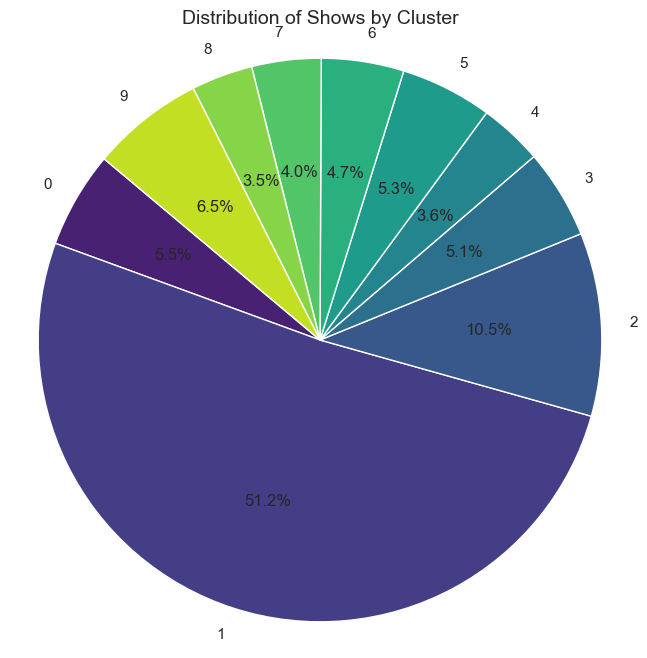

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

cluster_counts = df_filtered['cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, color='steelblue')
plt.title("Number of Shows in Each KMeans Cluster", fontsize=14)
plt.xlabel("Cluster Number")
plt.ylabel("Number of Show/Movies")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(cluster_counts.values, labels=cluster_counts.index,
        autopct='%1.1f%%', startangle=140,
        colors=sns.color_palette("viridis", n_colors=10))
plt.title("Distribution of Shows by Cluster", fontsize=14)
plt.axis('equal')
plt.show()


Original dataset shape: genre_label
9     1600
5     1210
0      859
7      829
12     774
3      605
6      399
13     388
16     334
10     275
2      253
8      221
1      176
11     128
17     120
15     120
4       80
18      67
19      65
14      57
Name: count, dtype: int64
Resampled dataset shape: genre_label
7     1600
12    1600
6     1600
8     1600
18    1600
3     1600
9     1600
2     1600
5     1600
17    1600
19    1600
10    1600
13    1600
0     1600
15    1600
1     1600
11    1600
4     1600
16    1600
14    1600
Name: count, dtype: int64


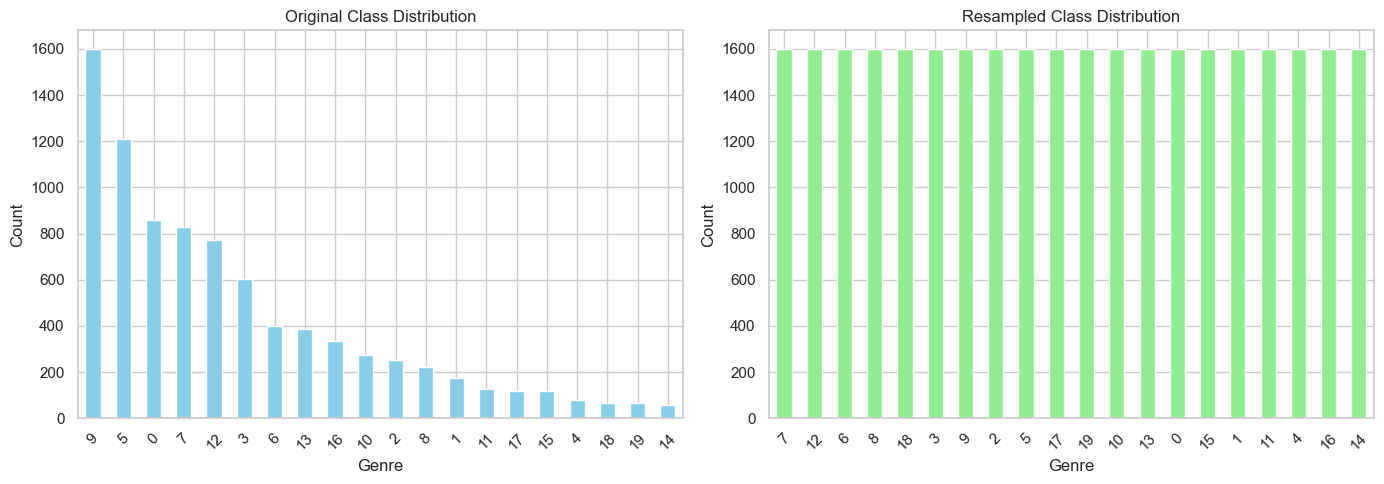

In [14]:
from imblearn.over_sampling import RandomOverSampler

x = tfidf_matrix
y = df_filtered['genre_label']
ros = RandomOverSampler(random_state = 42)
X_resampled, y_resampled = ros.fit_resample(x,y)
print("Original dataset shape:", y.value_counts())
print("Resampled dataset shape:", pd.Series(y_resampled).value_counts())

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

y.value_counts().plot(kind='bar', ax=axs[0], color='skyblue')
axs[0].set_title('Original Class Distribution')
axs[0].set_xlabel('Genre')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=45)

pd.Series(y_resampled).value_counts().plot(kind='bar', ax=axs[1], color='lightgreen')
axs[1].set_title('Resampled Class Distribution')
axs[1].set_xlabel('Genre')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 42)
X_resampled, y_resampled = ros.fit_resample(tfidf_matrix, df_filtered['genre_label'])

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

Accuracy: 0.8978125
                          precision    recall  f1-score   support

      Action & Adventure       0.80      0.79      0.79       327
            Anime Series       0.96      1.00      0.98       316
        British TV Shows       0.95      0.96      0.96       324
Children & Family Movies       0.85      0.85      0.85       327
          Classic Movies       0.99      1.00      1.00       322
                Comedies       0.73      0.64      0.68       353
          Crime TV Shows       0.80      0.88      0.84       325
           Documentaries       0.92      0.85      0.88       332
              Docuseries       0.94      0.99      0.96       303
                  Dramas       0.58      0.46      0.51       312
           Horror Movies       0.91      0.99      0.95       312
    International Movies       0.97      1.00      0.98       319
  International TV Shows       0.74      0.69      0.71       315
                Kids' TV       0.90      0.93      0.91

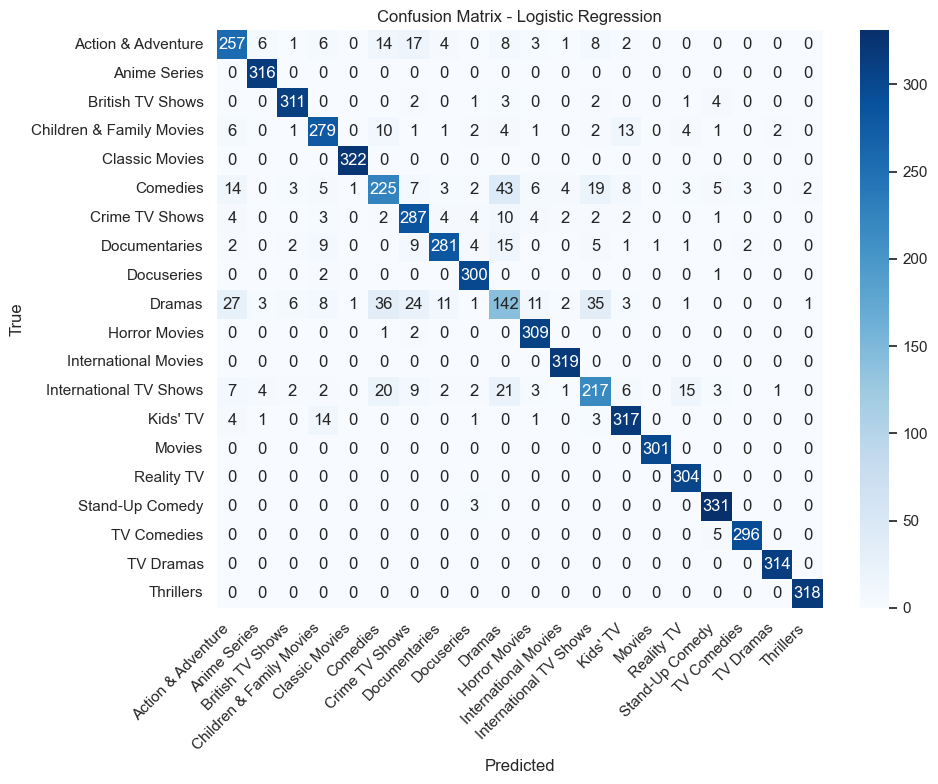

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm_logreg = confusion_matrix(y_test, log_reg.predict(X_test))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],       # Inverse of regularization strength
    'penalty': ['l2'],                  # Regularization type (LogisticRegression only supports 'l2' for solvers below)
    'solver': ['lbfgs', 'liblinear']    # Solvers that support L2
}

log_reg = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_log_reg = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_pred = best_log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.9321875
                          precision    recall  f1-score   support

      Action & Adventure       0.83      0.83      0.83       327
            Anime Series       0.98      1.00      0.99       316
        British TV Shows       0.97      1.00      0.98       324
Children & Family Movies       0.94      0.94      0.94       327
          Classic Movies       1.00      1.00      1.00       322
                Comedies       0.77      0.72      0.74       353
          Crime TV Shows       0.88      0.97      0.92       325
           Documentaries       0.93      0.90      0.92       332
              Docuseries       0.97      1.00      0.99       303
                  Dramas       0.64      0.54      0.58       312
           Horror Movies       0.96      0.99      0.98       312
    International Movies       0.98      1.00      0.99       3

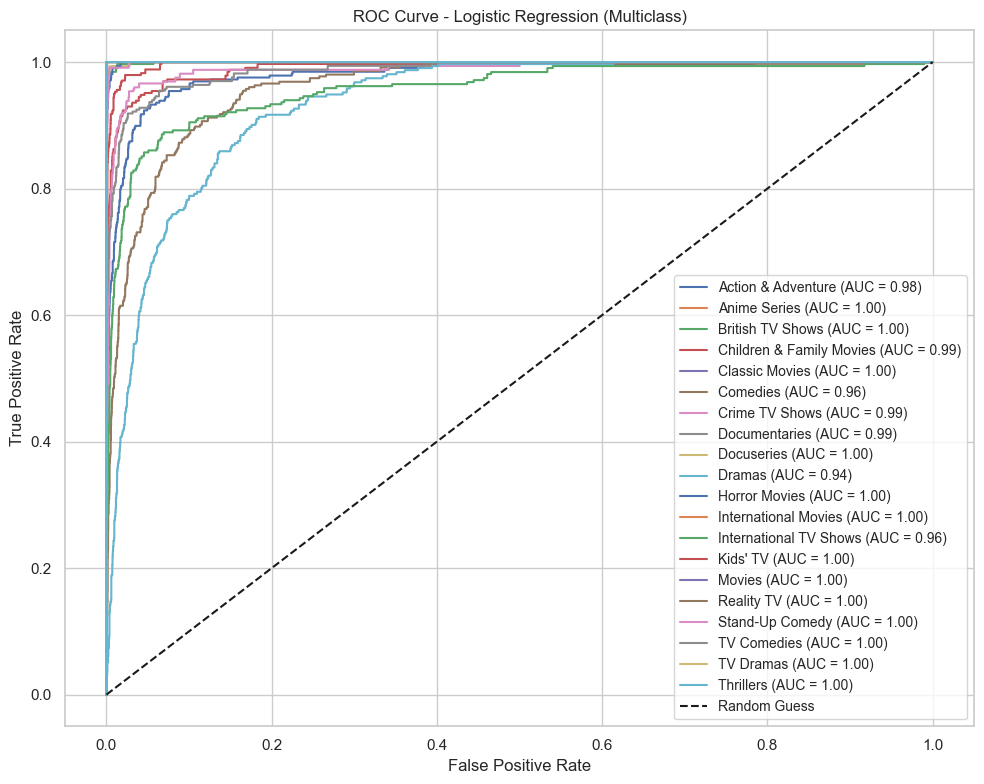

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Make sure your training and test data are ready: X_train, X_test, y_train, y_test
# Also, 'le' is your LabelEncoder

# Re-initialize and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict probabilities
y_proba_lr = log_reg.predict_proba(X_test)

# Binarize the true labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))

# Plot ROC Curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_proba_lr.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_lr[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_proba_lr[:, i])
    plt.plot(fpr[i], tpr[i], label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Multiclass)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()



In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 42)
X_resampled, y_resampled = ros.fit_resample(tfidf_matrix, df_filtered['genre_label'])                                    

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

Accuracy: 0.92015625
                          precision    recall  f1-score   support

      Action & Adventure       0.87      0.78      0.82       327
            Anime Series       0.99      1.00      1.00       316
        British TV Shows       0.99      1.00      0.99       324
Children & Family Movies       0.91      0.94      0.92       327
          Classic Movies       1.00      1.00      1.00       322
                Comedies       0.77      0.60      0.68       353
          Crime TV Shows       0.85      0.97      0.90       325
           Documentaries       0.94      0.84      0.89       332
              Docuseries       0.95      1.00      0.97       303
                  Dramas       0.49      0.58      0.54       312
           Horror Movies       0.97      0.99      0.98       312
    International Movies       0.99      1.00      1.00       319
  International TV Shows       0.85      0.77      0.81       315
                Kids' TV       0.96      0.98      0.9

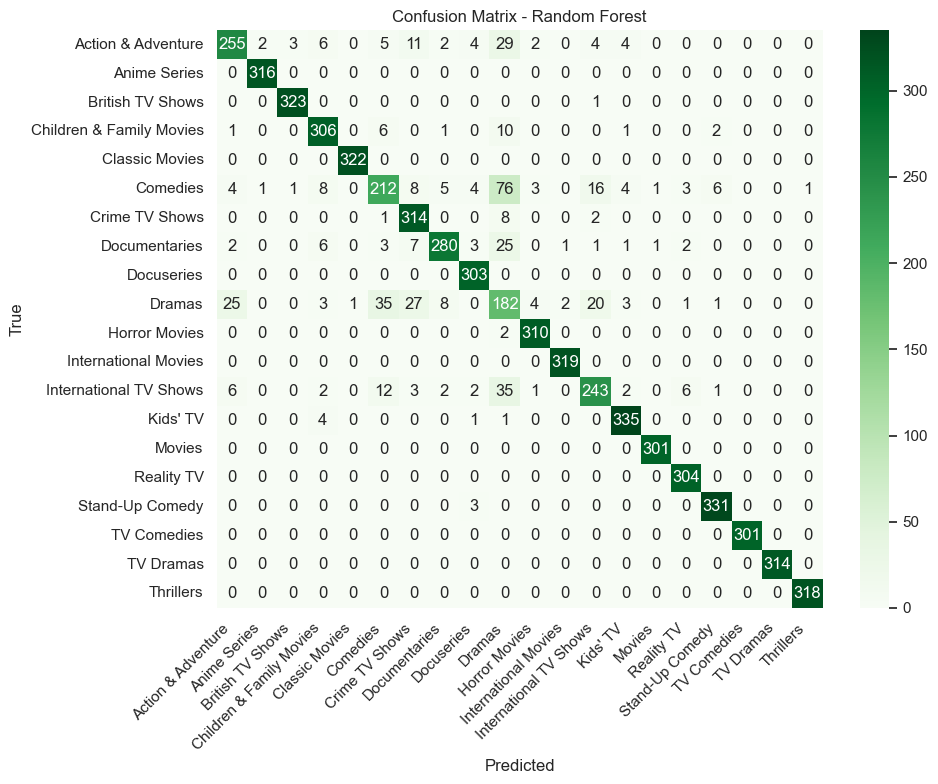

In [20]:
cm_rf = confusion_matrix(y_test, rf.predict(X_test))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, 
                              scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

y_pred_rf = best_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.92265625
                          precision    recall  f1-score   support

      Action & Adventure       0.89      0.79      0.84       327
            Anime Series       0.99      1.00      1.00       316
        British TV Shows       0.98      1.00      0.99       324
Children & Family Movies       0.91      0.92      0.92       327
          Classic Movies       1.00      1.00      1.00       322
                Comedies       0.76      0.61      0.68       353
          Crime TV Shows       0.86      0.97      0.91       325
           Documentaries       0.93      0.86      0.89       332
              Docuseries       0.96      1.00      0.98       303
                  Dramas       0.51      0.61      0.55       312
           Horror Movies       0.97      0.99      0.98       312
 

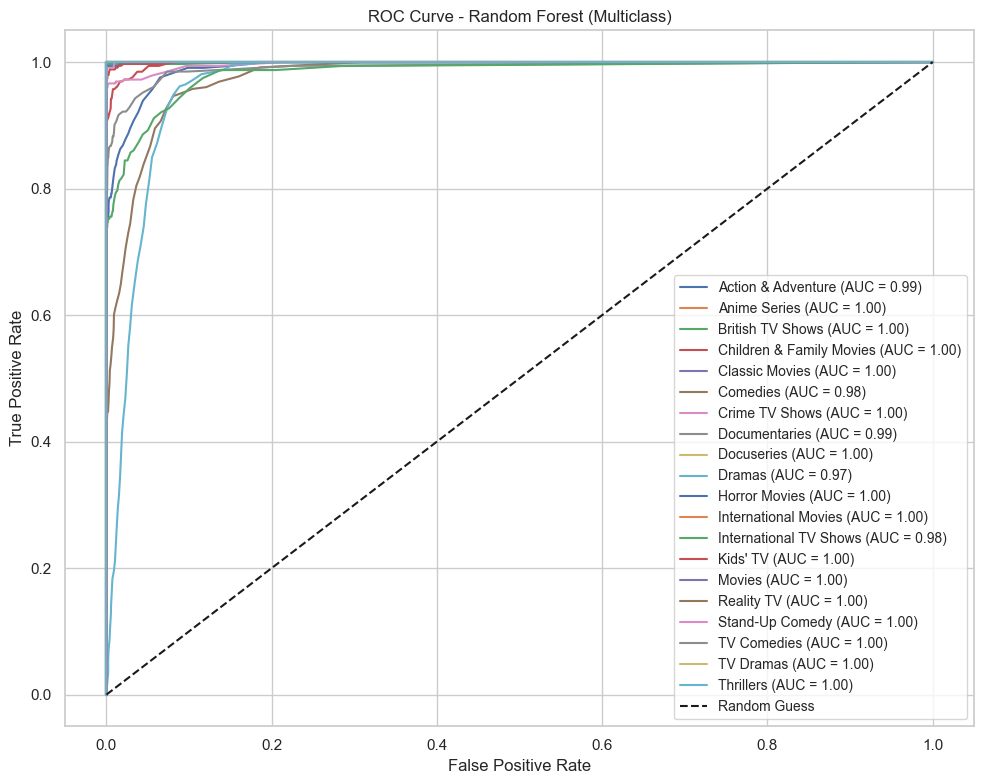

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_proba_rf = rf.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))

fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
n_classes = y_proba_rf.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], y_proba_rf[:, i])
    roc_auc_rf[i] = roc_auc_score(y_test_bin[:, i], y_proba_rf[:, i])
    plt.plot(fpr_rf[i], tpr_rf[i], label=f"{le.classes_[i]} (AUC = {roc_auc_rf[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve - Random Forest (Multiclass)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer

ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(x, y)

X_train, X_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

labels_in_test = sorted(list(set(y_test)))
target_names = [le.classes_[i] for i in labels_in_test]
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, labels=labels_in_test, target_names=target_names, zero_division=0))


Accuracy: 0.8671875
                          precision    recall  f1-score   support

      Action & Adventure       0.83      0.70      0.76       327
            Anime Series       0.91      1.00      0.95       316
        British TV Shows       0.95      0.93      0.94       324
Children & Family Movies       0.86      0.82      0.84       327
          Classic Movies       0.92      1.00      0.96       322
                Comedies       0.77      0.53      0.63       353
          Crime TV Shows       0.76      0.91      0.83       325
           Documentaries       0.96      0.69      0.80       332
              Docuseries       0.83      0.99      0.90       303
                  Dramas       0.60      0.31      0.41       312
           Horror Movies       0.84      0.99      0.91       312
    International Movies       0.86      1.00      0.93       319
  International TV Shows       0.74      0.62      0.67       315
                Kids' TV       0.90      0.93      0.91

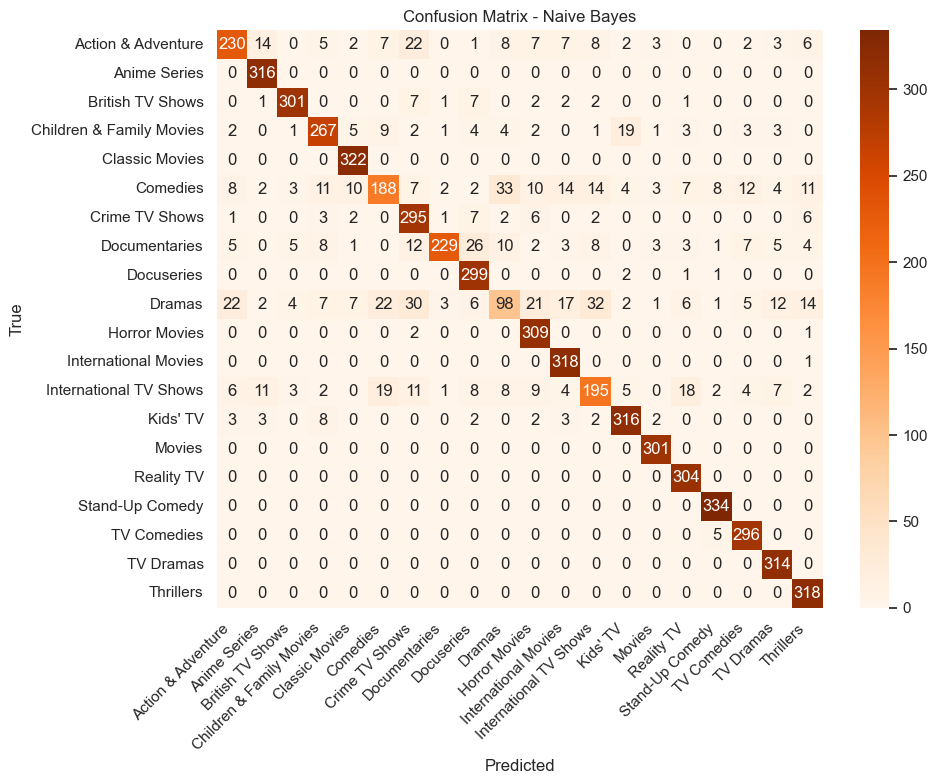

In [24]:
cm_nb = confusion_matrix(y_test, nb.predict(X_test))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0] 
}

nb = MultinomialNB()

grid_search_nb = GridSearchCV(estimator=nb, param_grid=param_grid_nb, 
                              scoring='accuracy', cv=5, verbose=1, n_jobs=1)

grid_search_nb.fit(X_train, y_train)

best_nb = grid_search_nb.best_estimator_
print("Best Parameters for Naive Bayes:", grid_search_nb.best_params_)

y_pred_nb = best_nb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, target_names=le.classes_, zero_division=0))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters for Naive Bayes: {'alpha': 0.1}
Accuracy: 0.9175
                          precision    recall  f1-score   support

      Action & Adventure       0.85      0.84      0.84       327
            Anime Series       0.98      1.00      0.99       316
        British TV Shows       0.98      0.99      0.99       324
Children & Family Movies       0.88      0.88      0.88       327
          Classic Movies       0.99      1.00      0.99       322
                Comedies       0.74      0.69      0.72       353
          Crime TV Shows       0.86      0.95      0.90       325
           Documentaries       0.96      0.84      0.89       332
              Docuseries       0.92      1.00      0.96       303
                  Dramas       0.62      0.50      0.56       312
           Horror Movies       0.95      1.00      0.97       312
    International Movies       0.97      1.00      0.98       319
  International 

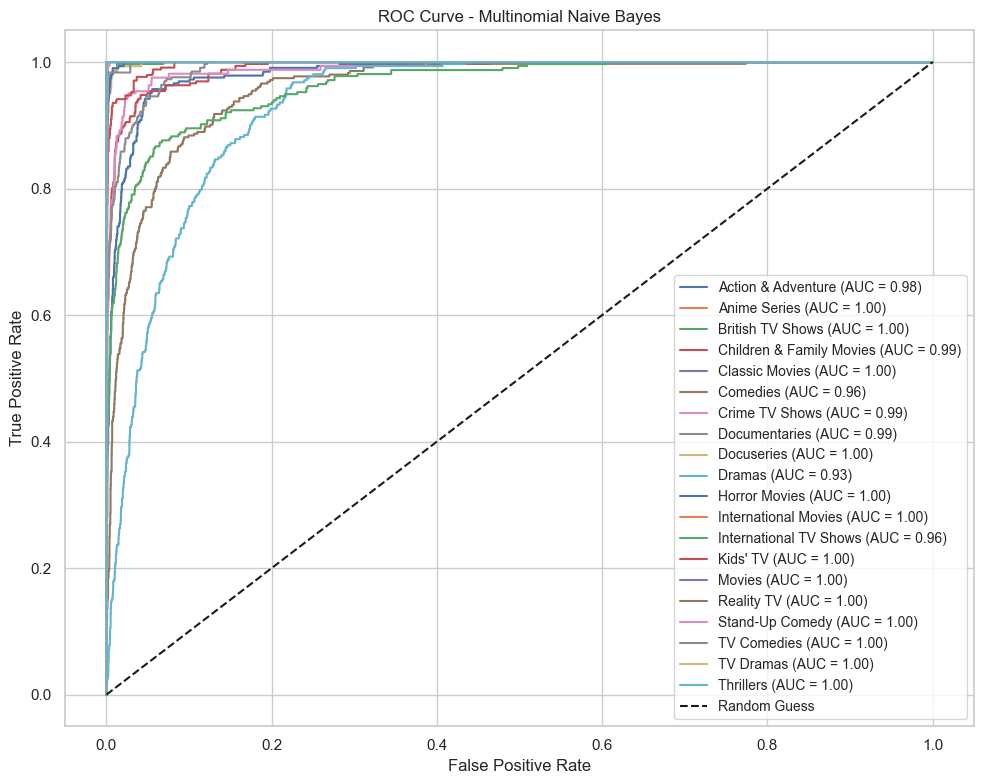

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Re-train Naive Bayes if needed
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predict class probabilities
y_proba_nb = nb.predict_proba(X_test)

# Binarize the true labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))

# Prepare ROC curve data
fpr_nb = dict()
tpr_nb = dict()
roc_auc_nb = dict()
n_classes = y_proba_nb.shape[1]

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr_nb[i], tpr_nb[i], _ = roc_curve(y_test_bin[:, i], y_proba_nb[:, i])
    roc_auc_nb[i] = roc_auc_score(y_test_bin[:, i], y_proba_nb[:, i])
    plt.plot(fpr_nb[i], tpr_nb[i], label=f"{le.classes_[i]} (AUC = {roc_auc_nb[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve - Multinomial Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(tfidf_matrix, df_filtered['genre_label'])

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

svc = LinearSVC(max_iter=1000)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))


Accuracy: 0.9253125
                          precision    recall  f1-score   support

      Action & Adventure       0.84      0.82      0.83       327
            Anime Series       0.97      1.00      0.98       316
        British TV Shows       0.98      1.00      0.99       324
Children & Family Movies       0.91      0.93      0.92       327
          Classic Movies       0.98      1.00      0.99       322
                Comedies       0.78      0.69      0.73       353
          Crime TV Shows       0.85      0.97      0.90       325
           Documentaries       0.94      0.89      0.91       332
              Docuseries       0.97      1.00      0.99       303
                  Dramas       0.65      0.47      0.55       312
           Horror Movies       0.95      0.99      0.97       312
    International Movies       0.97      1.00      0.98       319
  International TV Shows       0.79      0.80      0.80       315
                Kids' TV       0.95      0.98      0.97

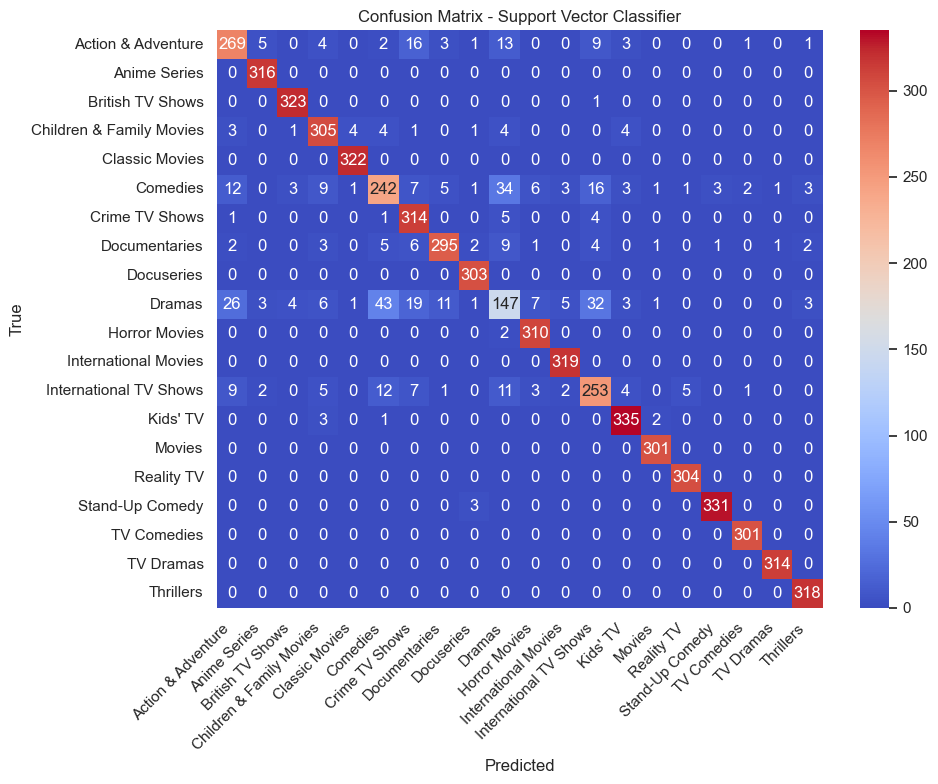

In [28]:
cm_svc = confusion_matrix(y_test, svc.predict(X_test))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Support Vector Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

param_grid_svc = {
    'C': [0.01, 0.1, 1, 10],     
    'max_iter': [1000, 2000]
}

svc = LinearSVC(max_iter=1000)

grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc,
                            scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search_svc.fit(X_train, y_train)

best_svc = grid_search_svc.best_estimator_
print("Best Parameters for Support Vector Classifier:", grid_search_svc.best_params_)

y_pred = best_svc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Predator-User\Desktop\genre_predict\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters for Support Vector Classifier: {'C': 10, 'max_iter': 1000}
Accuracy: 0.92640625
                          precision    recall  f1-score   support

      Action & Adventure       0.83      0.84      0.84       327
            Anime Series       0.98      1.00      0.99       316
        British TV Shows       0.98      1.00      0.99       324
Children & Family Movies       0.89      0.94      0.91       327
          Classic Movies       0.98      1.00      0.99       322
                Comedies       0.76      0.69      0.72       353
          Crime TV Shows       0.88      0.97      0.92       325
           Documentaries       0.94      0.88      0.91       332
              Docuseries       0.97      1.00      0.99       303
                  Dramas       0.64      0.46      0.54       312
           Horror Movies       0.96      0.99      0.97       312
    International Movies       0.98      1.00      0.99       319
  International TV Shows       0.78      0.82

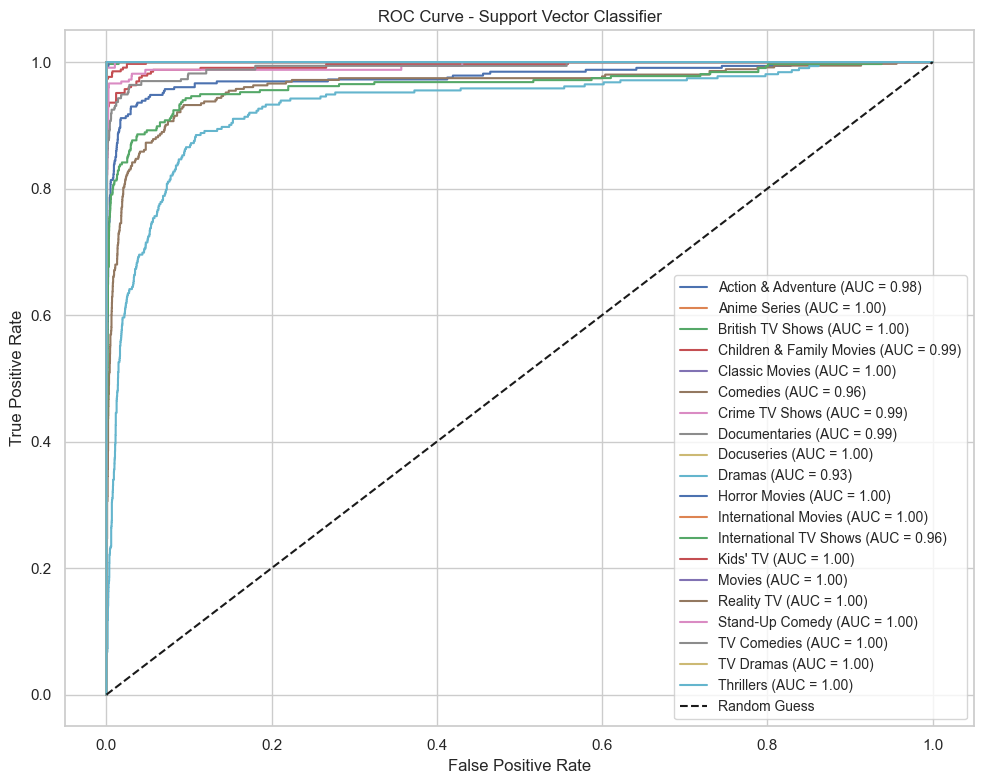

In [30]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

svc = LinearSVC(max_iter=1000, random_state=42)
svc_calibrated = CalibratedClassifierCV(svc)
svc_calibrated.fit(X_train, y_train)

y_proba_svc = svc_calibrated.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_proba_svc.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_svc[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_proba_svc[:, i])
    plt.plot(fpr[i], tpr[i], label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Classifier')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import PassiveAggressiveClassifier

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(tfidf_matrix, df_filtered['genre_label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train model
pac = PassiveAggressiveClassifier(C=0.5, max_iter=1000, random_state=42)
pac.fit(X_train, y_train)

# Predict and evaluate
y_pred = pac.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))


Accuracy: 0.92703125
                          precision    recall  f1-score   support

      Action & Adventure       0.82      0.84      0.83       327
            Anime Series       0.97      1.00      0.99       316
        British TV Shows       0.98      1.00      0.99       324
Children & Family Movies       0.91      0.94      0.92       327
          Classic Movies       0.99      1.00      1.00       322
                Comedies       0.75      0.69      0.72       353
          Crime TV Shows       0.88      0.97      0.92       325
           Documentaries       0.94      0.89      0.91       332
              Docuseries       0.97      1.00      0.99       303
                  Dramas       0.62      0.47      0.54       312
           Horror Movies       0.95      0.99      0.97       312
    International Movies       0.99      1.00      0.99       319
  International TV Shows       0.79      0.82      0.80       315
                Kids' TV       0.96      0.98      0.9

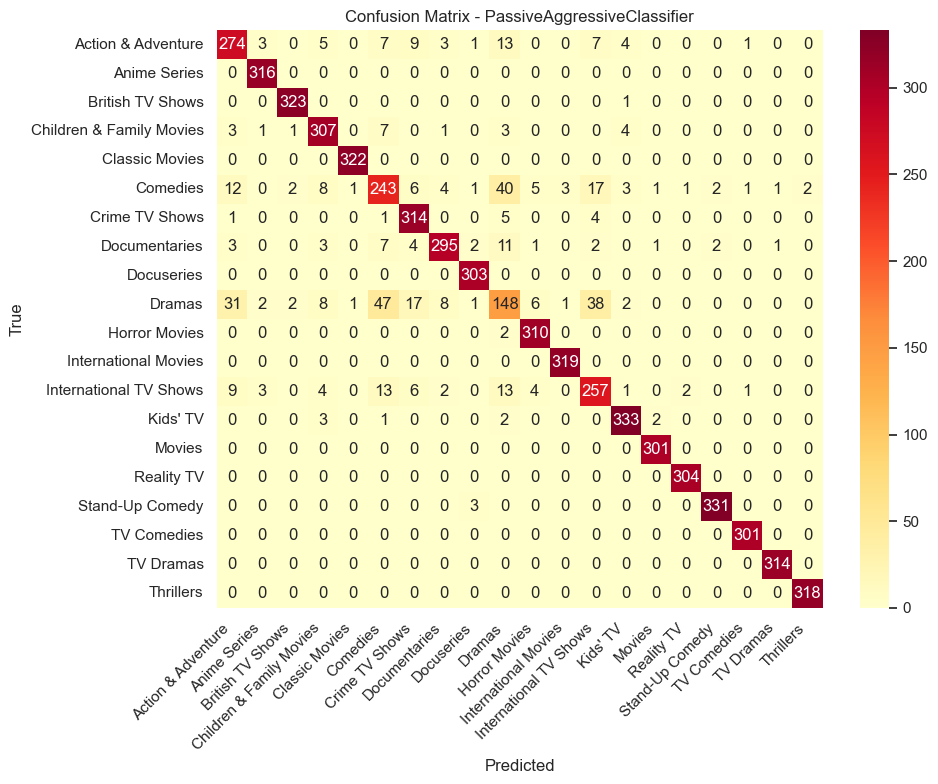

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix for PassiveAggressiveClassifier
cm_pac = confusion_matrix(y_test, pac.predict(X_test))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_pac, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - PassiveAggressiveClassifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [33]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid
param_grid_pac = {
    'C': [0.01, 0.1, 1.0, 10.0],             # Regularization strength
    'max_iter': [500, 1000, 1500],           # Number of training iterations
    'loss': ['hinge', 'squared_hinge']       # Type of loss function
}

# Initialize classifier
pac = PassiveAggressiveClassifier(random_state=42)

# Set up GridSearchCV
grid_search_pac = GridSearchCV(
    estimator=pac,
    param_grid=param_grid_pac,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit on training data (sparse matrix is fine)
grid_search_pac.fit(X_train, y_train)

# Get the best model and evaluate
best_pac = grid_search_pac.best_estimator_
print("Best Parameters:", grid_search_pac.best_params_)

y_pred = best_pac.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 500}
Accuracy: 0.92734375
                          precision    recall  f1-score   support

      Action & Adventure       0.82      0.84      0.83       327
            Anime Series       0.97      1.00      0.99       316
        British TV Shows       0.98      1.00      0.99       324
Children & Family Movies       0.92      0.94      0.93       327
          Classic Movies       1.00      1.00      1.00       322
                Comedies       0.75      0.69      0.72       353
          Crime TV Shows       0.87      0.97      0.92       325
           Documentaries       0.95      0.89      0.91       332
              Docuseries       0.97      1.00      0.99       303
                  Dramas       0.63      0.48      0.55       312
           Horror Movies       0.95      0.99      0.97       312
    International Movies       0.98      1.00      0.9

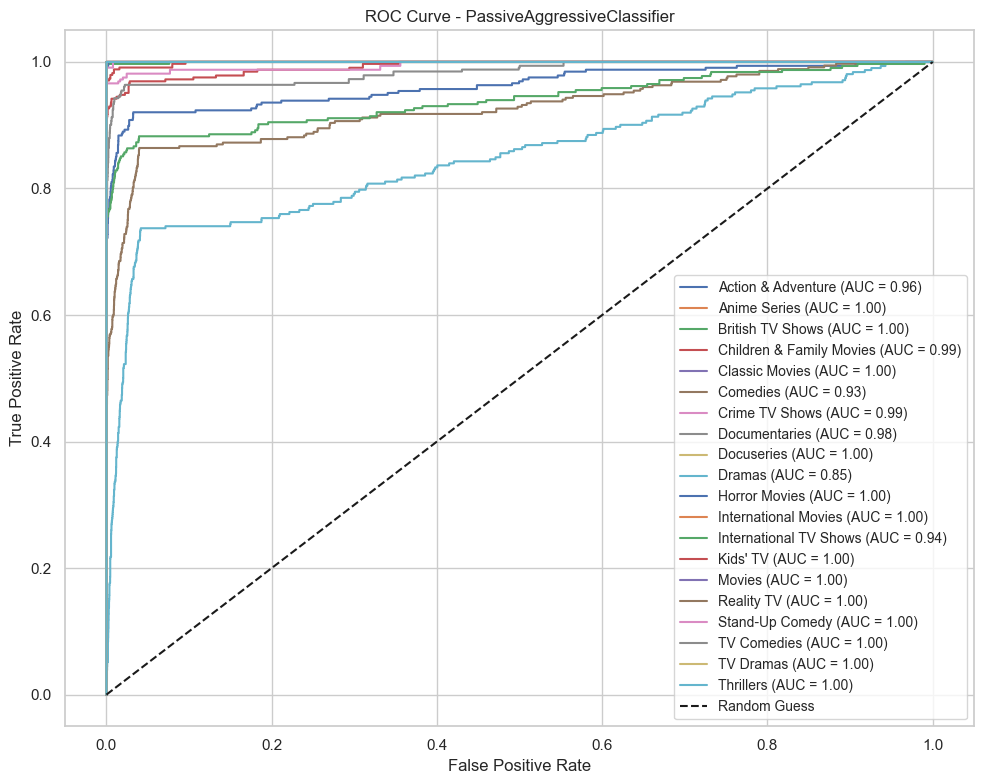

In [34]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Train model
pac = PassiveAggressiveClassifier(random_state=42)
pac.fit(X_train, y_train)

# Get decision scores (since predict_proba is not available)
y_scores = pac.decision_function(X_test)

# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))

# Prepare ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_scores[:, i])
    plt.plot(fpr[i], tpr[i], label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - PassiveAggressiveClassifier')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


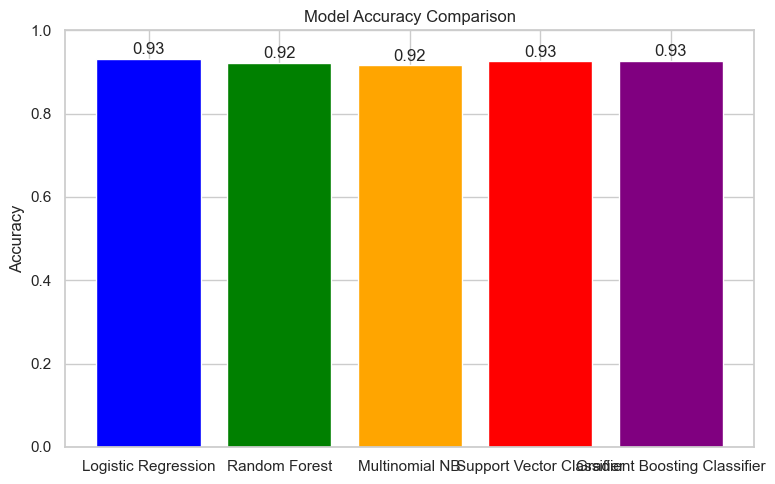

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

acc_logreg = accuracy_score(y_test, best_log_reg.predict(X_test))
acc_rf = accuracy_score(y_test, best_rf.predict(X_test))
acc_nb = accuracy_score(y_test, best_nb.predict(X_test))
acc_svc = accuracy_score(y_test, best_svc.predict(X_test))
acc_pac = accuracy_score(y_test, best_pac.predict(X_test))

models = ['Logistic Regression', 'Random Forest', 'Multinomial NB', 'Support Vector Classifier', 'Gradient Boosting Classifier']
accuracies = [acc_logreg, acc_rf, acc_nb, acc_svc, acc_pac]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', fontsize=12)
plt.tight_layout()
plt.show()


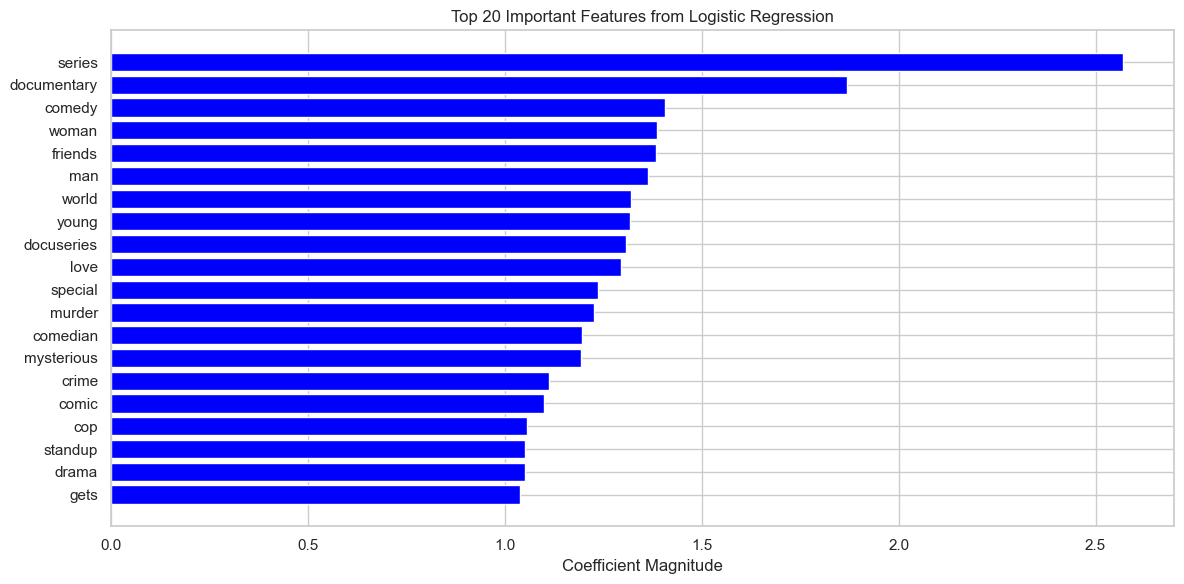

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feature_names = tfidf.get_feature_names_out()
coefficients = log_reg.coef_

avg_coefficients = np.mean(np.abs(coefficients), axis=0)

feat_imp_lr = pd.DataFrame({
    'feature': feature_names,
    'importance': avg_coefficients
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feat_imp_lr['feature'].head(20)[::-1], feat_imp_lr['importance'].head(20)[::-1], color='blue')
plt.xlabel('Coefficient Magnitude')
plt.title('Top 20 Important Features from Logistic Regression')
plt.tight_layout()
plt.show()


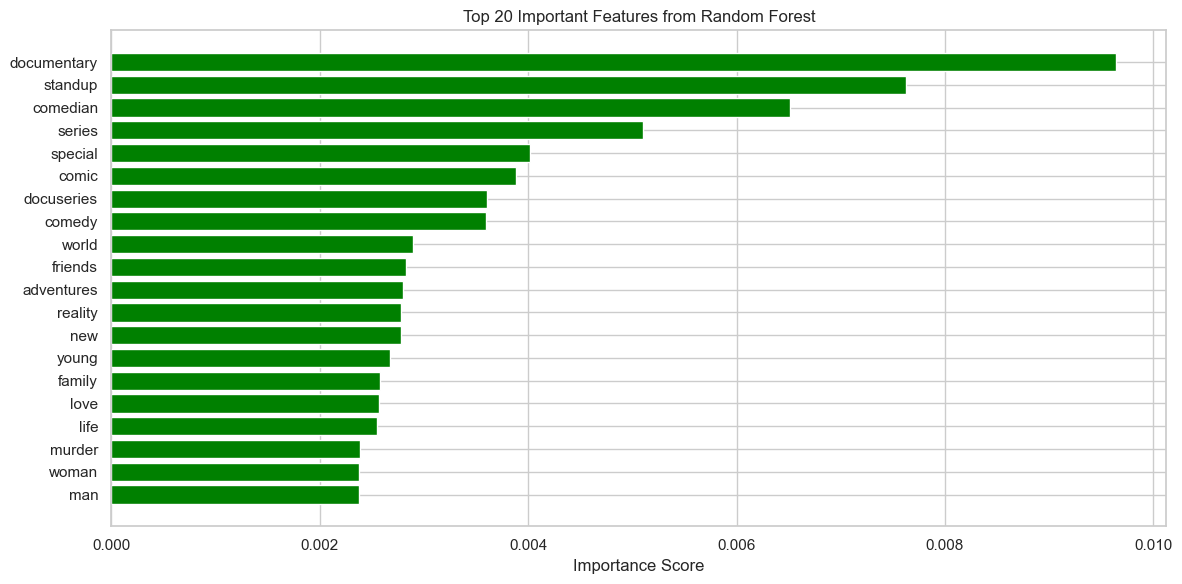

In [37]:
feature_names = tfidf.get_feature_names_out()

importances = rf.feature_importances_

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feat_imp_df['feature'].head(20)[::-1], feat_imp_df['importance'].head(20)[::-1], color='green')
plt.xlabel('Importance Score')
plt.title('Top 20 Important Features from Random Forest')
plt.tight_layout()
plt.show()


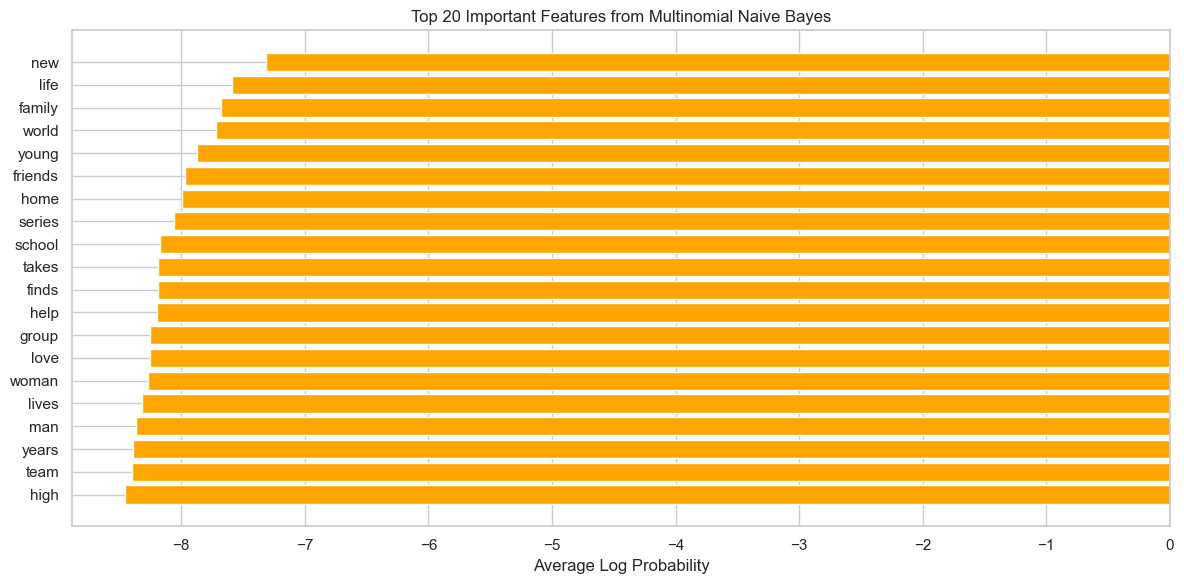

In [38]:
feature_names = tfidf.get_feature_names_out()
class_log_probs = nb.feature_log_prob_

avg_log_probs = np.mean(class_log_probs, axis=0)

feat_imp_nb = pd.DataFrame({
    'feature': feature_names,
    'importance': avg_log_probs
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feat_imp_nb['feature'].head(20)[::-1], feat_imp_nb['importance'].head(20)[::-1], color='orange')
plt.xlabel('Average Log Probability')
plt.title('Top 20 Important Features from Multinomial Naive Bayes')
plt.tight_layout()
plt.show()


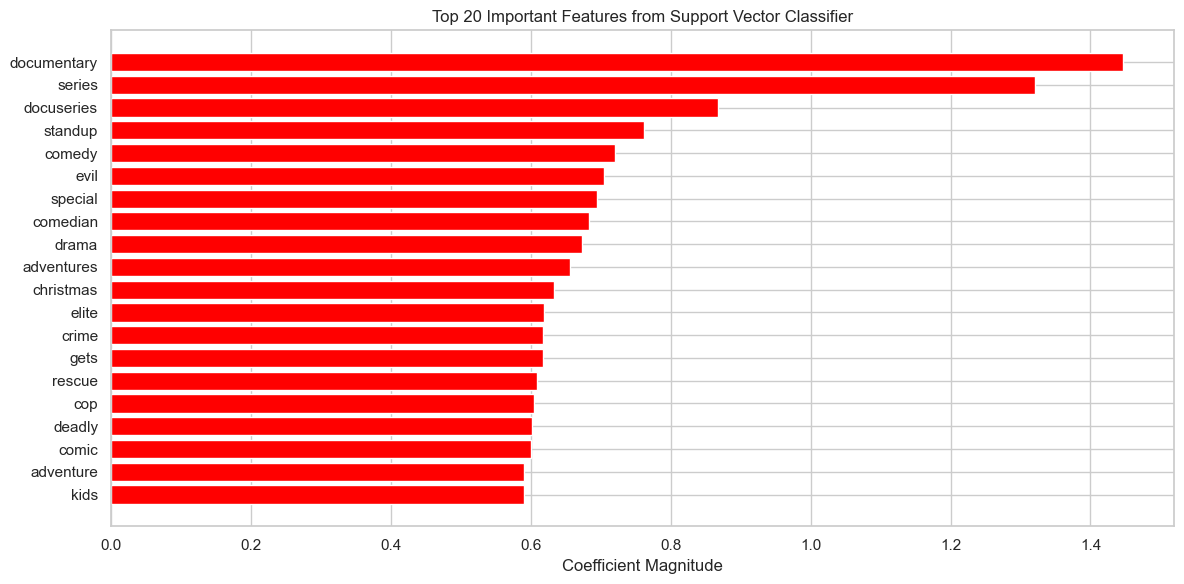

In [39]:
feature_names = tfidf.get_feature_names_out()

coefficients = best_svc.coef_ 

avg_coefficients = np.mean(np.abs(coefficients), axis=0)

feat_imp_svc = pd.DataFrame({
    'feature': feature_names,
    'importance': avg_coefficients
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feat_imp_svc['feature'].head(20)[::-1], feat_imp_svc['importance'].head(20)[::-1], color='red')
plt.xlabel('Coefficient Magnitude')
plt.title('Top 20 Important Features from Support Vector Classifier')
plt.tight_layout()
plt.show()

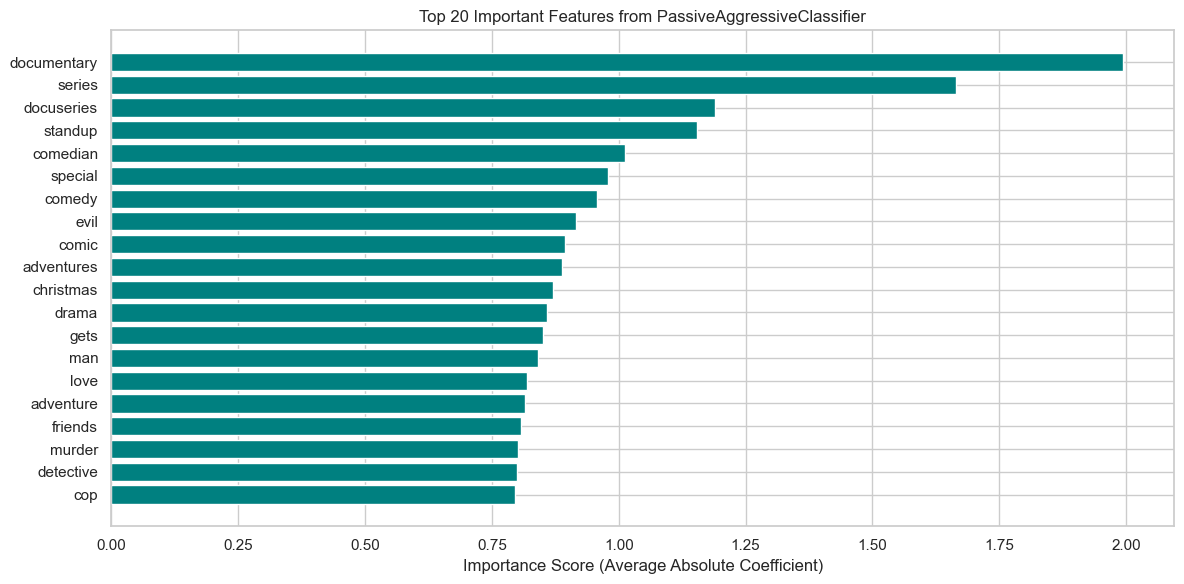

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get feature names from TF-IDF
feature_names = tfidf.get_feature_names_out()

# Get coefficients (1 row per class if multi-class)
coef = pac.coef_

# For multi-class, take the average absolute weight across classes
importance = np.mean(np.abs(coef), axis=0)

# Create DataFrame
feat_imp_pac = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# Plot top 20 important features
plt.figure(figsize=(12, 6))
plt.barh(feat_imp_pac['feature'].head(20)[::-1], feat_imp_pac['importance'].head(20)[::-1], color='teal')
plt.xlabel('Importance Score (Average Absolute Coefficient)')
plt.title('Top 20 Important Features from PassiveAggressiveClassifier')
plt.tight_layout()
plt.show()


In [41]:
def get_recommendation_filtered(title, top_n=10, genre_filter=None, type_filter=None):
    title = title.lower()
    if title not in indices:
        return f"'{title}' not found in the dataset."
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    sim_scores = sim_scores[1:]

    sim_df = pd.DataFrame(sim_scores, columns=['index', 'score'])
    sim_df = df.loc[sim_df['index']].copy()
    sim_df['similarity'] = [score for _, score in sim_scores]

    if genre_filter:
        sim_df = sim_df[sim_df['main_genre'].str.lower() == genre_filter.lower()]
    if type_filter:
        sim_df = sim_df[sim_df['type'].str.lower() == type_filter.lower()]

    return sim_df[['title', 'type', 'main_genre', 'similarity']].head(top_n)

In [42]:
get_recommendation_filtered("Narcos", top_n=5)

,title,type,main_genre,similarity
1397,A Monster Calls,Movie,Dramas,0.206705
219,EDENS ZERO,TV Show,Anime Series,0.180194
7262,Lady in the Water,Movie,Sci-Fi & Fantasy,0.172545
7061,In The Deep,Movie,Horror Movies,0.161893
6885,Gossip Girl,TV Show,TV Dramas,0.143348


In [43]:
get_recommendation_filtered("Narcos", top_n=5, genre_filter="Crime")
get_recommendation_filtered("Narcos", top_n=5, type_filter="TV Show")

,title,type,main_genre,similarity
219,EDENS ZERO,TV Show,Anime Series,0.180194
6885,Gossip Girl,TV Show,TV Dramas,0.143348
3279,The Club,TV Show,Crime TV Shows,0.141424
538,The A List,TV Show,British TV Shows,0.140049
3066,Mia and Me,TV Show,Kids' TV,0.139483


In [44]:
get_recommendation_filtered("Narcos", top_n=5, type_filter="TV Show")

,title,type,main_genre,similarity
219,EDENS ZERO,TV Show,Anime Series,0.180194
6885,Gossip Girl,TV Show,TV Dramas,0.143348
3279,The Club,TV Show,Crime TV Shows,0.141424
538,The A List,TV Show,British TV Shows,0.140049
3066,Mia and Me,TV Show,Kids' TV,0.139483


In [45]:
get_recommendation_filtered("Narcos", top_n=5)
get_recommendation_filtered("Narcos", top_n=5, type_filter="TV Show")

,title,type,main_genre,similarity
219,EDENS ZERO,TV Show,Anime Series,0.180194
6885,Gossip Girl,TV Show,TV Dramas,0.143348
3279,The Club,TV Show,Crime TV Shows,0.141424
538,The A List,TV Show,British TV Shows,0.140049
3066,Mia and Me,TV Show,Kids' TV,0.139483


In [46]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def predict_genre_from_text(text, model, vectorizer, label_encoder):
    text_vector = vectorizer.transform([text])
    prediction = model.predict(text_vector)
    return label_encoder.inverse_transform(prediction)[0]

In [47]:
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

text_input = "As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and...."
cleaned_input = clean_text(text_input)

genre_prediction = predict_genre_from_text(cleaned_input, best_log_reg, tfidf, le)

print("Predicted Genre:", genre_prediction)

Predicted Genre: Documentaries
